In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = './FINALSOUNDS/'

data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
sounds = np.array(tf.io.gfile.listdir(str(data_dir)))
sounds = sounds[(sounds != 'README.md') & (sounds != '.DS_Store')]
print('sounds:', sounds)

sounds: ['ambulance' 'firetruck' 'traffic']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=48000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 599 files belonging to 3 classes.
Using 480 files for training.
Using 119 files for validation.

label names: ['ambulance' 'firetruck' 'traffic']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# Remove any extra dimensions of size 1 to give a 1D audio signal
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
# Split into validation and testing sets 
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 48000)
(64,)


In [ ]:
label_names[[1,1,2,0]]

array(['firetruck', 'firetruck', 'traffic', 'ambulance'], dtype='<U9')

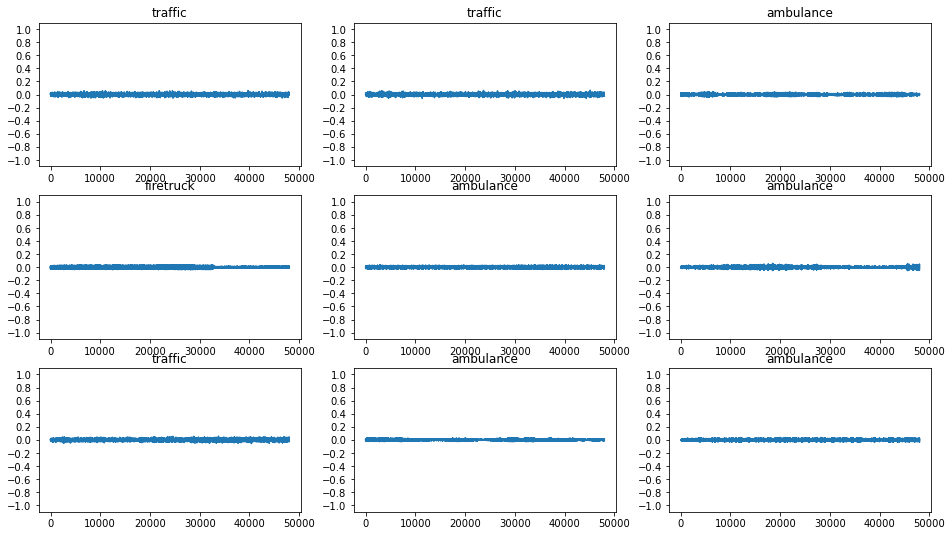

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: traffic
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: traffic
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: ambulance
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

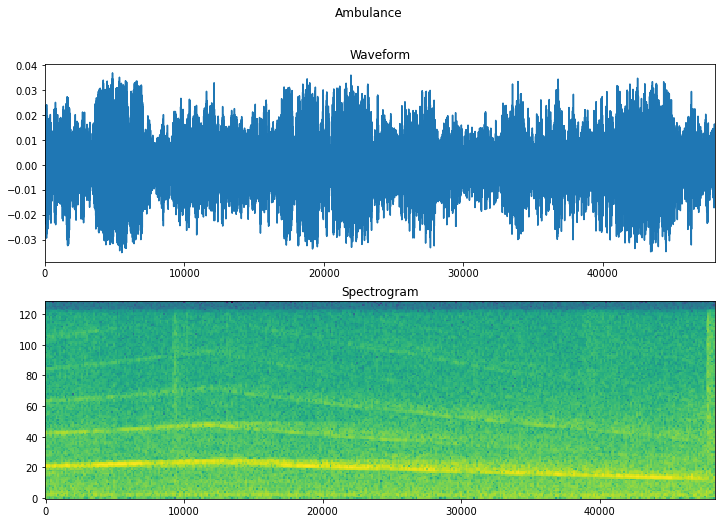

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

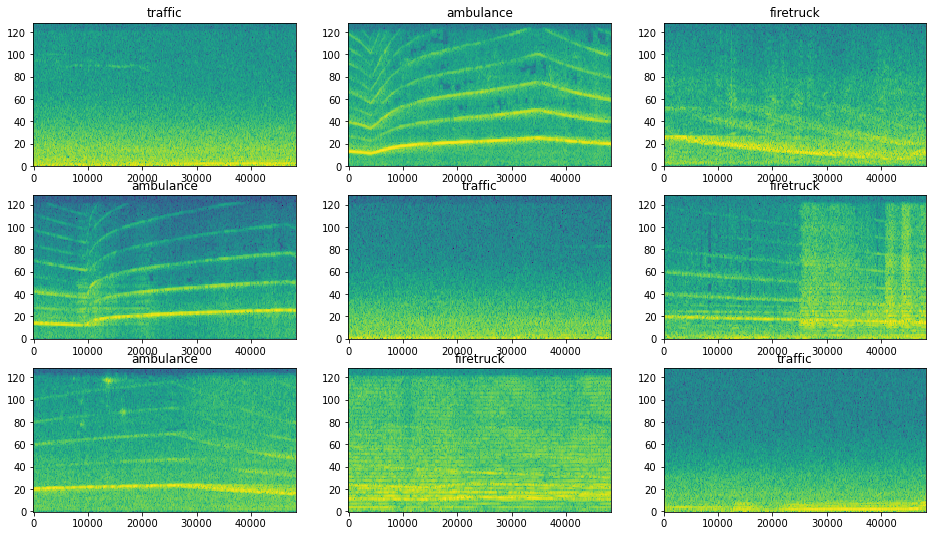

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (374, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
8/8 [==============================] - 5s 354ms/step - loss: 0.6445 - accuracy: 0.6979 - val_loss: 0.4296 - val_accuracy: 0.8182
Epoch 2/50
8/8 [==============================] - 1s 173ms/step - loss: 0.2319 - accuracy: 0.9125 - val_loss: 0.3885 - val_accuracy: 0.8545
Epoch 3/50
8/8 [==============================] - 1s 171ms/step - loss: 0.1515 - accuracy: 0.9458 - val_loss: 0.4403 - val_accuracy: 0.8545
Epoch 4/50
8/8 [==============================] - 1s 174ms/step - loss: 0.1165 - accuracy: 0.9583 - val_loss: 0.3919 - val_accuracy: 0.8909
Epoch 5/50
8/8 [==============================] - 1s 170ms/step - loss: 0.1018 - accuracy: 0.9771 - val_loss: 0.4297 - val_accuracy: 0.8727
Epoch 6/50
8/8 [==============================] - 1s 172ms/step - loss: 0.0894 - accuracy: 0.9729 - val_loss: 0.3792 - val_accuracy: 0.8909
Epoch 7/50
8/8 [==============================] - 1s 168ms/step - loss: 0.0674 - accuracy: 0.9792 - val_loss: 0.4557 - val_accuracy: 0.8545
Epoch 8/50
8/8 [====

Text(0, 0.5, 'Accuracy [%]')

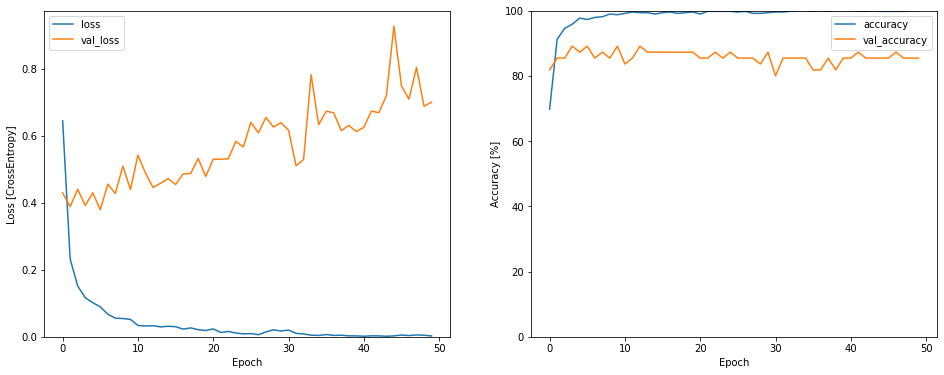

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 1s 1s/step - loss: 0.9770 - accuracy: 0.8125


{'loss': 0.9770321846008301, 'accuracy': 0.8125}

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 314ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

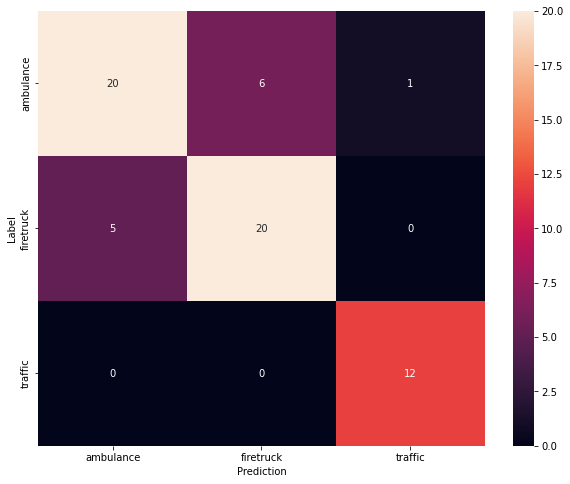

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

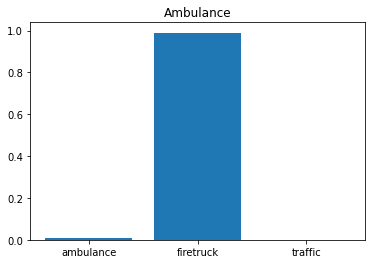

In [ ]:
x = './FINALSOUNDS/firetruck/[chunk][38][16][MONO] sound_20-01-01.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels = 1, desired_samples = 48000,)
x = tf.squeeze(x, axis = -1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['ambulance', 'firetruck', 'traffic']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ambulance')
plt.show()

display.display(display.Audio(waveform, rate = 16000))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

## Export the model - Haya

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

## Converting tflite model to c binaries (haya)

In [ ]:
!xxd -i model.tflite > model.h